# Imports and Dataset Setup

In [2]:
!pip install torch torchvision timm medmnist grad-cam matplotlib
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

In [10]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, models
import torch.optim as optim
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import matplotlib.pyplot as plt
import numpy as np

from medmnist import INFO, ChestMNIST
import medmnist

torch.manual_seed(42)

CUDA available: True
Device: cuda


# Load ChestMNIST Dataset + Preprocessing

In [4]:
# Get dataset info
info = INFO['chestmnist']
n_classes = len(info['label'])

# Data transformations
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

# Load training and test datasets
train_dataset = ChestMNIST(split='train', transform=data_transform, download=True)
test_dataset = ChestMNIST(split='test', transform=data_transform, download=True)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#  Define and Modify the Model (ResNet18)

In [5]:
# Load ResNet-18 with pretrained weights
model = models.resnet18(pretrained=True)

# Modify the final fully connected layer
# ChestMNIST is multi-label with 14 binary labels
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 14),
    nn.Sigmoid()  # Sigmoid for multi-label classification
)
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Loss Function, Optimizer & Training Loop Setup

In [7]:
# Binary Cross Entropy for multi-label classification
criterion = nn.BCELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 15  # you can increase later
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float()  # convert labels to float for BCELoss

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward + Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()


    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}")

Epoch [1/15], Loss: 372.1966
Epoch [2/15], Loss: 357.2488
Epoch [3/15], Loss: 331.3118
Epoch [4/15], Loss: 285.0181
Epoch [5/15], Loss: 217.2697
Epoch [6/15], Loss: 149.1875
Epoch [7/15], Loss: 99.7632
Epoch [8/15], Loss: 75.0807
Epoch [9/15], Loss: 60.9249
Epoch [10/15], Loss: 53.5080
Epoch [11/15], Loss: 48.7181
Epoch [12/15], Loss: 44.3500
Epoch [13/15], Loss: 40.6174
Epoch [14/15], Loss: 37.6671
Epoch [15/15], Loss: 35.1180


# Evaluation Block (for ChestMNIST + ResNet18)

In [8]:
model.eval()
correct = 0
total = 0
threshold = 0.5
running_loss = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).float()
        outputs = model(images)

        # Apply sigmoid since we're using BCEWithLogitsLoss
        preds = torch.sigmoid(outputs) > threshold

        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Simple accuracy calculation
        correct += (preds == labels.bool()).sum().item()
        total += labels.numel()

avg_test_loss = running_loss / len(test_loader)
accuracy = 100 * correct / total

print(f"\n Test Loss: {avg_test_loss:.4f}")
print(f" Multi-label Accuracy: {accuracy:.2f}%\n")


 Test Loss: 0.4940
 Multi-label Accuracy: 43.59%



# GradCAM Code Block (for ChestMNIST with ResNet18)

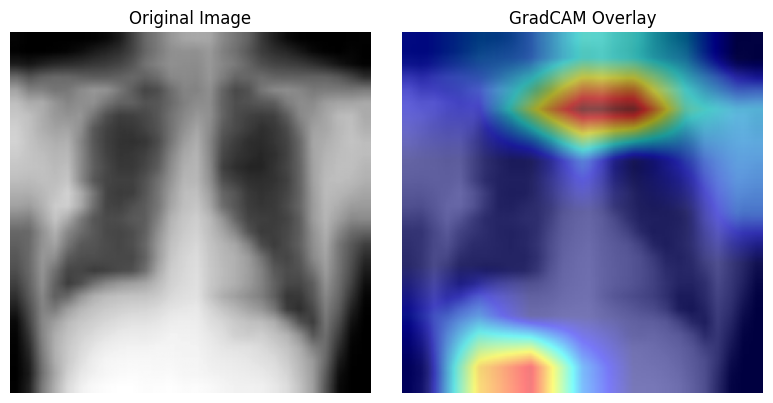

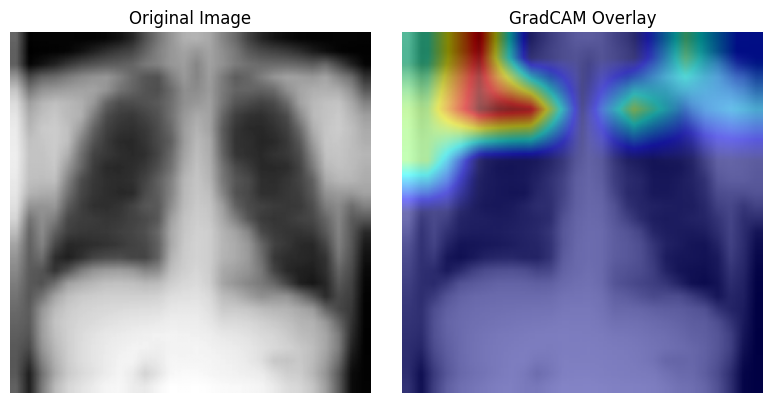

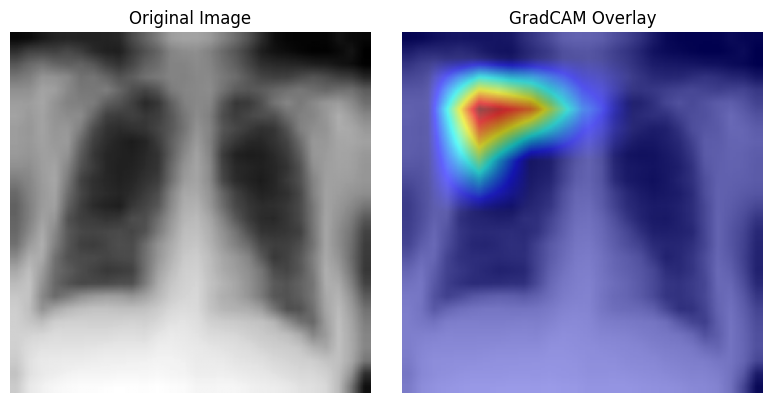

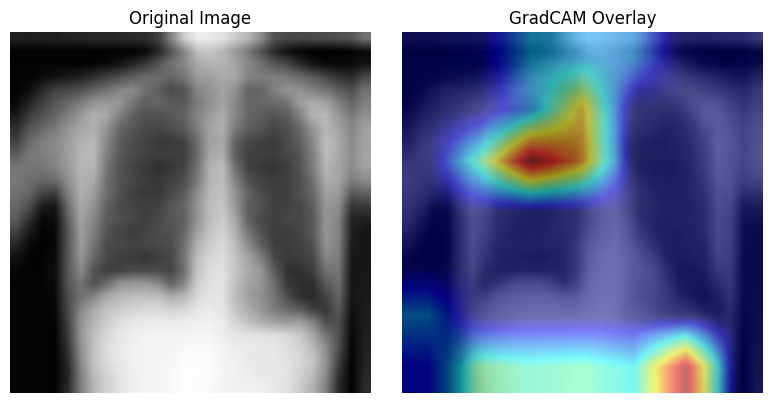

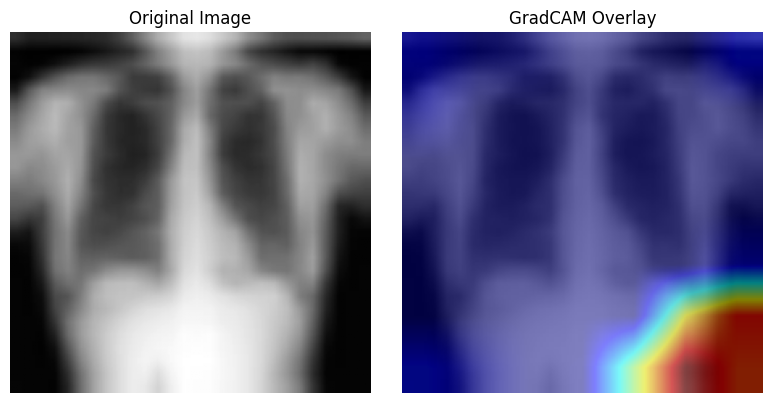

In [15]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import matplotlib.pyplot as plt
import numpy as np

# Move model to device (already done during training, but ensure it)
model.to(device)
model.eval()

# Choose the target layer for GradCAM
target_layer = model.layer4[-1]

# Create the GradCAM object — no use_cuda
cam = GradCAM(model=model, target_layers=[target_layer])

# Get a batch from the test set
images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)

# Visualize a few examples
for i in range(5):
    input_tensor = images[i].unsqueeze(0)  # add batch dim

    if input_tensor.shape[1] == 1:
      input_3ch = input_tensor.expand(-1, 3, -1, -1)
    else:
      input_3ch = input_tensor

    # Visualize for class 0 (Atelectasis) – change index if needed
    targets = [ClassifierOutputTarget(0)]

    # Compute GradCAM
    grayscale_cam = cam(input_tensor=input_3ch, targets=targets)[0]

    # Normalize input for overlay
    rgb_image = input_3ch[0].cpu().numpy().transpose(1, 2, 0)
    rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

    cam_image = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

    # Plot
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(rgb_image[:, :, 0], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("GradCAM Overlay")
    plt.imshow(cam_image)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Save GradCAM Overlay Images

In [16]:
import os
from PIL import Image

# Create directory to store GradCAM results
os.makedirs("gradcam_outputs", exist_ok=True)

# Loop through a few test images
for i in range(5):
    input_tensor = images[i].unsqueeze(0)

    # Fix: expand to 3 channels only if needed
    if input_tensor.shape[1] == 1:
        input_3ch = input_tensor.expand(-1, 3, -1, -1)
    else:
        input_3ch = input_tensor

    # Define target class (e.g., class 0)
    targets = [ClassifierOutputTarget(0)]

    # Generate GradCAM
    grayscale_cam = cam(input_tensor=input_3ch, targets=targets)[0]

    # Normalize input for visualization
    rgb_image = input_3ch[0].cpu().numpy().transpose(1, 2, 0)
    rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

    cam_image = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

    # Convert NumPy image to PIL Image and save
    cam_pil = Image.fromarray(cam_image)
    cam_pil.save(f"gradcam_outputs/sample_{i+1}.png")

    print(f" Saved: gradcam_outputs/sample_{i+1}.png")

 Saved: gradcam_outputs/sample_1.png
 Saved: gradcam_outputs/sample_2.png
 Saved: gradcam_outputs/sample_3.png
 Saved: gradcam_outputs/sample_4.png
 Saved: gradcam_outputs/sample_5.png


# Create Side-by-Side GIF from Saved GradCAM Outputs

In [17]:
from PIL import Image

# Load images from the saved outputs
image_paths = [f"gradcam_outputs/sample_{i+1}.png" for i in range(5)]
frames = [Image.open(img_path).convert("RGB") for img_path in image_paths]

# Save as animated GIF
gif_path = "gradcam_outputs/gradcam_demo.gif"
frames[0].save(
    gif_path,
    format="GIF",
    append_images=frames[1:],
    save_all=True,
    duration=800,  # milliseconds per frame
    loop=0
)

print(f" GIF saved at: {gif_path}")

 GIF saved at: gradcam_outputs/gradcam_demo.gif
